# Research of flat adverts

You have at your disposal data from the Yandex.Real Estate service - an archive of advertisements for flats for sale in St. Petersburg and neighbouring cities for several years. You need to learn how to determine the market value of real estate objects. Your task is to set the parameters. This will allow you to build an automated system: it will track anomalies and fraudulent activity. 

For each flat for sale, two types of data are available. The first is entered by the user, the second is obtained automatically on the basis of map data. For example, the distance to the centre, airport, nearest park and water body. 

For the analysis we have provided a data set containing real estate ads for sale in St. Petersburg and Leningrad region for 2014-2018.

The following steps will be taken in the course of the analysis:
1) Initial evaluation of the dataset;
2) Data preprocessing (enrichment, work with missing values, work with data types, data normalisation);
3) Adding calculated analytical values;
4) Analysing data, working with outliers;
5) Exploring data relationships.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

#### Checking general information about the dataset

In [3]:
pd.set_option('display.max_columns', 50) 
print(df.head())
print(df.info())
print(df.describe())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт

#### Building a histogram over all numeric columns

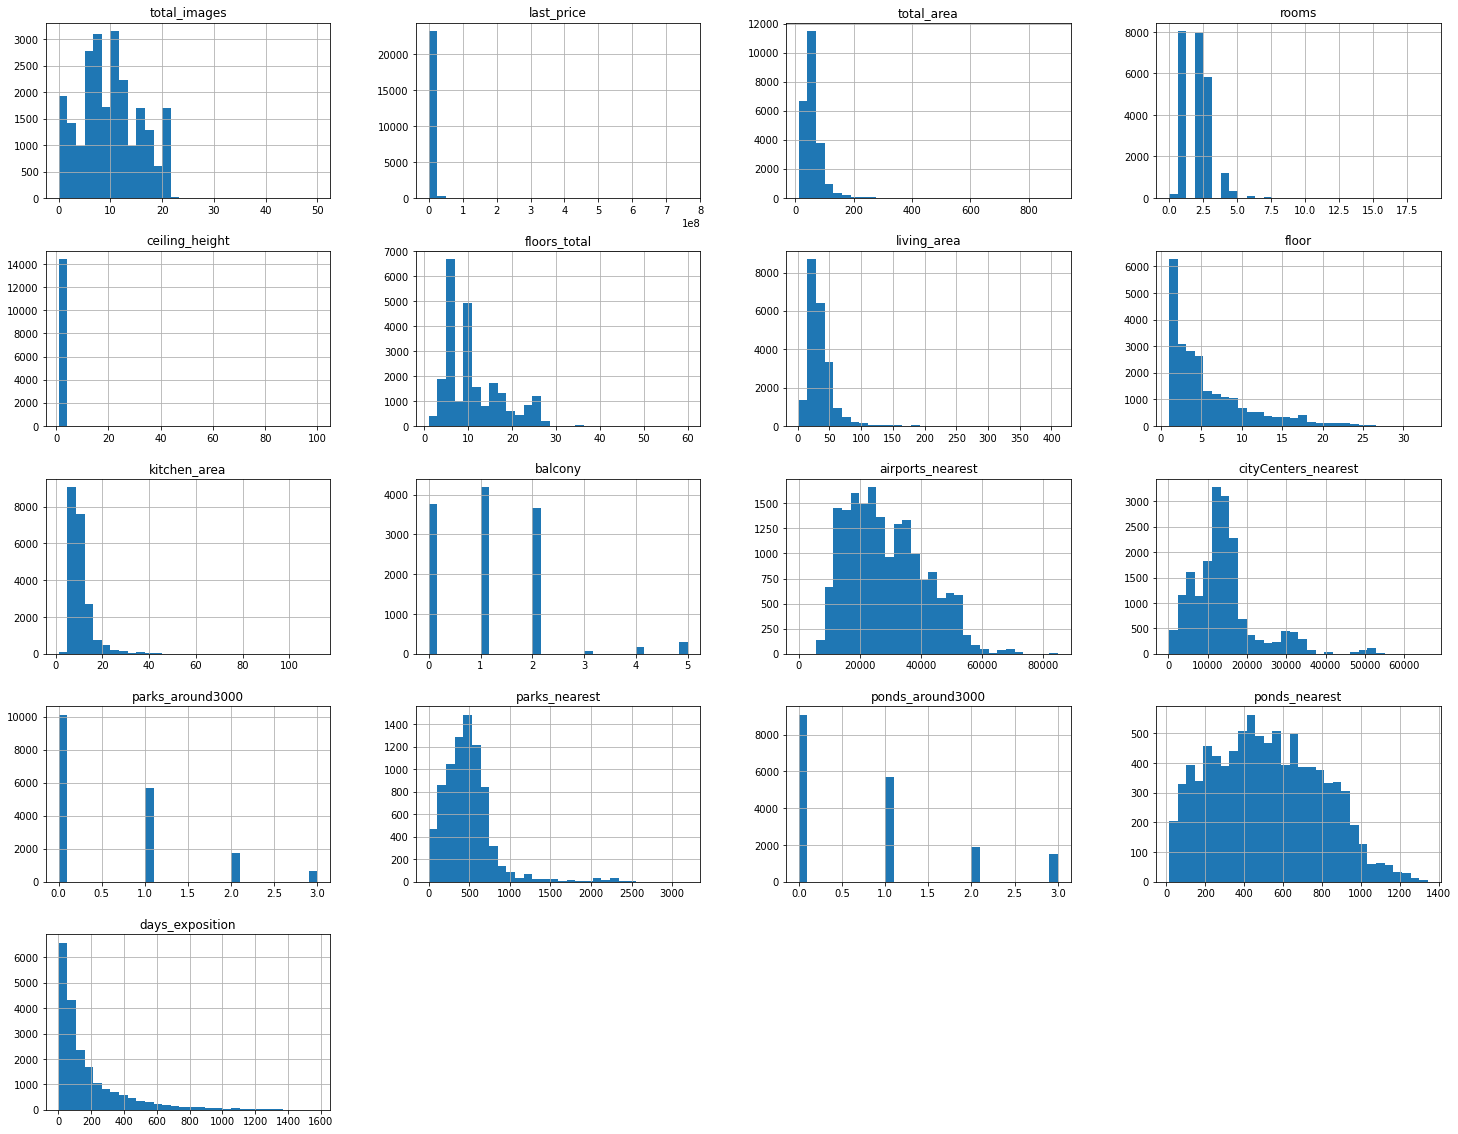

In [5]:
df.hist(figsize = (25,20), bins = 30)
None

### Data preprocessing

#### Determine in which columns and how many columns there are missing values

In [6]:
nan_dict = {}
for col_name in df.columns:
    count_nan = df[col_name].isna().sum()
    if count_nan>0:
        nan_dict[col_name] = [count_nan, round(count_nan/df.shape[0]*100, 1)]

print(nan_dict)

{'ceiling_height': [9195, 38.8], 'floors_total': [86, 0.4], 'living_area': [1903, 8.0], 'is_apartment': [20924, 88.3], 'kitchen_area': [2278, 9.6], 'balcony': [11519, 48.6], 'locality_name': [49, 0.2], 'airports_nearest': [5542, 23.4], 'cityCenters_nearest': [5519, 23.3], 'parks_around3000': [5518, 23.3], 'parks_nearest': [15620, 65.9], 'ponds_around3000': [5518, 23.3], 'ponds_nearest': [14589, 61.6], 'days_exposition': [3181, 13.4]}


Let's identify the information we can fill in.

#### Enrichment of ceiling height data

We can fill in the missing ceiling heights with the median value, the interquartile range is very narrow, all values lie in a narrow corridor.

In [7]:
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].median()
df['ceiling_height'].isna().sum()

0

#### Handling missing values locational name

locality_name has a small number of observations where no location is specified, we can delete the data

In [8]:
df = df.dropna(subset = ['locality_name'])
df['locality_name'].isna().sum()

0

#### Handling missing values of storey totals

Let's replace the missing values of floors_total with the median values by location, since the development is likely to be similar

In [9]:
median_floors_loc = pd.pivot_table(df, columns =['locality_name'] , values = 'floors_total', aggfunc = 'mean')
median_floors_loc = pd.Series(median_floors_loc.values[0], index = median_floors_loc.columns)
median_floors_loc = median_floors_loc.astype(int)
df['floors_total']=df['floors_total'].fillna(df['locality_name'].map(median_floors_loc))
df['floors_total'].isna().sum()

0

In case the floor of the sales announcement is higher than the total number of floors, we assign the value of the total floors to the floor of the flat.

In [10]:
df.loc[df['floors_total']<df['floor'], 'floor'] = df['floors_total']

#### Handling missing values number of balconies

We can replace missing values in the balcony category by 0

In [11]:
df.loc[df['balcony'].isna(), 'balcony'] = 0
df['balcony'].isna().sum()

0

#### Handling missing values appartement signage

We can replace missing values in the is_apartment category with false values

In [12]:
df.loc[df['is_apartment'].isna(), 'is_apartment'] = False
df['is_apartment'].isna().sum()

0

#### Handling missing values number of parks and ponds within a 3 km radius

Let's check that for missing values in the category col v parkav and ponds in the radius of 3 km, the distance indicator to the nearest park and pond is more than 3 km or otsyvutvuet

In [13]:
print(df.query('parks_around3000.isna() and parks_nearest<3000').shape)
print(df.query('ponds_around3000.isna() and ponds_nearest<3000').shape)

(0, 22)
(0, 22)


We see that there are no intersections, so we can replace the missing values with zeros

In [14]:
df.loc[df['parks_around3000'].isna(), 'parks_around3000'] = 0
print(df['parks_around3000'].isna().sum())
df.loc[df['ponds_around3000'].isna(), 'ponds_around3000'] = 0
print(df['ponds_around3000'].isna().sum())

0
0


#### Handling missing living area values

Let's analyse the indicator living_area, the living area is the rooms, we can try to fill the missing value by calculating the average area of the room, by groups, if the range is small, we can multiply the average value by the number of rooms.

count    21569.000000
mean        16.692753
std          3.866244
min          1.000000
25%         14.433333
50%         16.000000
75%         18.000000
max         62.500000
dtype: float64


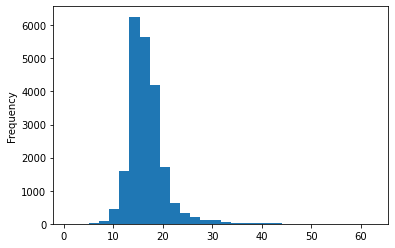

In [15]:
room_squere = df['living_area']/df['rooms']
room_squere = room_squere[room_squere!=np.inf]
room_squere.plot(kind = 'hist', bins = 30)
print(room_squere.describe())

As we can see the dome is very narrow, the standard deviation is small, half of the values are between 14.5 and 18 metres. Let's check if there is a significant difference in the groups by the number of rooms. Let's build a statistical table for 3 groups of 1, 2, 3 and more rooms, as well as allocate a group of studios, calculate the mean and median

In [16]:
room_squere = pd.DataFrame({'rooms': df['rooms'], 'studio': df['studio'], 'room_squere': room_squere})
room_squere.loc[room_squere['rooms']>3, 'rooms'] = 3
stat_table = pd.pivot_table(room_squere, 
                    values = 'room_squere',
                    index = 'rooms',
                    columns = 'studio',
                    aggfunc = ['mean', 'median'])
print(stat_table)

             mean                median      
studio      False      True       False True 
rooms                                        
1       17.890924  19.110909  17.600000  18.0
2       15.866076        NaN  15.250000   NaN
3       16.282613        NaN  15.233333   NaN


We see that the difference between the area of one room of two and three room flats is small and can be neglected.
While the average area of one room in a one-bedroom flat is much larger.
The difference between one-room flats and studios is also insignificant and can be neglected.

In [17]:
df.loc[(df['rooms']<=1) & (df['living_area'].isna()), 'living_area'] = df['rooms']*stat_table['median'][False].loc[1]
df.loc[(df['rooms']>1) & (df['living_area'].isna()), 'living_area'] = df['rooms']*stat_table['median'][False].loc[2]
print(df['living_area'].isna().sum())

0


Let's make sure there are no listings where the living space is larger than the total.

In [18]:
print(df.query('living_area>total_area').shape)

(24, 22)


We see that there are 24 such lines, for them we will calculate the residential zone as a ratio of residential zone to total zone.

In [19]:
percent_living_area = df['living_area']/df['total_area']
df.loc[df['living_area']>df['total_area'], 'living_area'] = df['total_area']*percent_living_area.median()
print(df.query('living_area>total_area').shape)

(0, 22)


#### Handling missing values Distance to nearest park and pond

We see a very large number of missing values in the columns distance to the nearest park and pond.
We can check if there are rows where the distance is unknown, but there is a desired place 3 km away.

In [20]:
print(df.query('ponds_nearest.isna() and ponds_around3000>0').shape)
print(df.query('parks_nearest.isna() and parks_around3000>0').shape)

(0, 22)
(0, 22)


There are no similar values

Possible reasons why missing values are present:
1) information simply not specified in the advert - ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony,
locality_name
2) the information was not identified as 0 when forming the upload - parks_around3000, ponds_around3000.
3) apparently there are errors in the algorithm of data calculation, or perhaps the name of the settlement point is specified incorrectly - airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest
4) the advert is apparently still active - days_exposition

#### Frame date data type analysis

In [21]:
print(df.dtypes)

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                   float64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object


We see that we have 3 columns with type object, let's fix them starting with first_day_exposition.

In [22]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

is_apartment let's put it into a budium value

In [23]:
df['is_apartment'] = df['is_apartment'].astype('bool')
print(df['first_day_exposition'].dtypes)
print(df['is_apartment'].dtypes)

datetime64[ns]
bool


The data type in columns should have been replaced because it is inconvenient to work with the object data type and it is impossible to do most of the actions with it, plus it saves memory and speeds up work.

Remove implicit duplicates of locality_name 

In [24]:
print(len(list(df['locality_name'].drop_duplicates().sort_values())))

364


Replace any duplicates found

In [25]:
df['locality_name'] = (df['locality_name'].replace(
['поселок Аннино','городской поселок Большая Ижора', 'поселок Бугры', 'поселок Возрождение', 'поселок городского типа Вырица','поселок станции Вещево', 'поселок Гарболово', 'поселок Гаврилово','поселок Громово', 'поселок Жилгородок', 'деревня Зимитицы', 'поселок Ильичёво','деревня Калитино','деревня Кудрово', 'поселок Кобралово',  'поселок Коробицыно',  'поселок городского типа Красный Бор', 'поселок городского типа Кузьмоловский', 'поселок Любань', 'поселок городского типа Лесогорский', 'коттеджный посёлок Лесное', 'поселок Лисий Нос',  'поселок городского типа Лебяжье',  'поселок Мурино', 'Мурино', 'городской посёлок Мга', 'поселок Мельниково', 'поселок Мичуринское', 'село Никольское', 'поселок городского типа Назия',  'поселок Новый Свет', 'посёлок городского типа Павлово',  'село Павлово', 'поселок Пансионат Зелёный Бор',  'поселок Перово', 'поселок Победа', 'поселок Поляны',  'поселок городского типа Приладожский',  'поселок станции Приветнинское',  'поселок городского типа Рощино', 'посёлок городского типа Рощино',  'деревня Рабитицы',  'деревня Реброво', 'поселок городского типа Рябово', 'посёлок городского типа Рябово', 'поселок городского типа Рахья','поселок городского типа Советский', 'поселок Стеклянный','поселок Сумино','поселок Тельмана','поселок Терволово', 'поселок городского типа Токсово','деревня Фёдоровское', 'поселок городского типа Форносово',  'деревня Щеглово',  'городской поселок Янино-1',  'поселок Усть-Луга',  'поселок городского типа имени Свердлова'],
['посёлок Аннино','поселок городского типа Большая Ижора', 'посёлок Бугры','посёлок Возрождение',  'посёлок городского типа Вырица', 'посёлок при железнодорожной станции Вещево','деревня Гарболово','посёлок Гаврилово', 'посёлок станции Громово', 'посёлок Жилгородок', 'поселок Зимитицы','посёлок Ильичёво', 'поселок Калитино','Кудрово','посёлок Кобралово','посёлок Коробицыно','посёлок городского типа Красный Бор','посёлок городского типа Кузьмоловский','Любань','городской посёлок Лесогорский', 'поселок Лесное',  'посёлок Лисий Нос',  'посёлок городского типа Лебяжье',  'посёлок Мурино',  'посёлок Мурино',  'посёлок городского типа Мга','посёлок Мельниково','посёлок Мичуринское','Никольское', 'городской посёлок Назия', 'посёлок Новый Свет','городской посёлок Павлово','городской посёлок Павлово',  'посёлок Пансионат Зелёный Бор',  'посёлок Перово', 'посёлок Победа', 'посёлок Поляны',  'садовое товарищество Приладожский', 'посёлок при железнодорожной станции Приветнинское',  'городской посёлок Рощино',  'городской посёлок Рощино',  'поселок Рабитицы',  'поселок Рябово',  'поселок Рябово',  'поселок Рябово',  'садовое товарищество Рахья',  'городской посёлок Советский',  'посёлок Стеклянный', 'посёлок Сумино', 'посёлок Тельмана',  'посёлок Терволово',  'посёлок городского типа Токсово',  'городской посёлок Фёдоровское',  'посёлок городского типа Форносово',  'посёлок Щеглово',  'городской посёлок Янино-1',  'посёлок Усть-Луга', 'посёлок городского типа имени Свердлова']
))
print(len(list(df['locality_name'].drop_duplicates().sort_values())))

306


#### Emissions processing in the dataset

The histograms of last_price, shows a strange distribution, the logarithmic scale indicates that there are extreme high values in the dataset

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64


(0.0, 15000000.0)

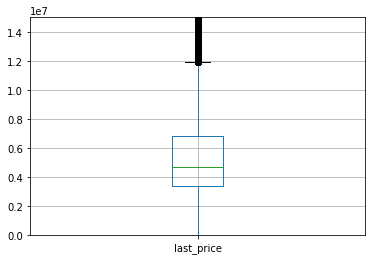

In [26]:
print(df['last_price'].describe())
df.boxplot('last_price')
plt.ylim([0,15000000])

The average is much higher than the median, the maximum value is measured in hundreds of millions and the graph shows more outliers, let's estimate the number of adverts with a price exceeding 20 million.

In [27]:
print(df.query('last_price>25000000').count())

total_images            464
last_price              464
total_area              464
first_day_exposition    464
rooms                   464
ceiling_height          464
floors_total            464
living_area             464
floor                   464
is_apartment            464
studio                  464
open_plan               464
kitchen_area            412
balcony                 464
locality_name           464
airports_nearest        447
cityCenters_nearest     452
parks_around3000        464
parks_nearest           329
ponds_around3000        464
ponds_nearest           344
days_exposition         341
dtype: int64


There are only 464 values, we can lose that much data, but first let's check how the distribution will look without this data

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

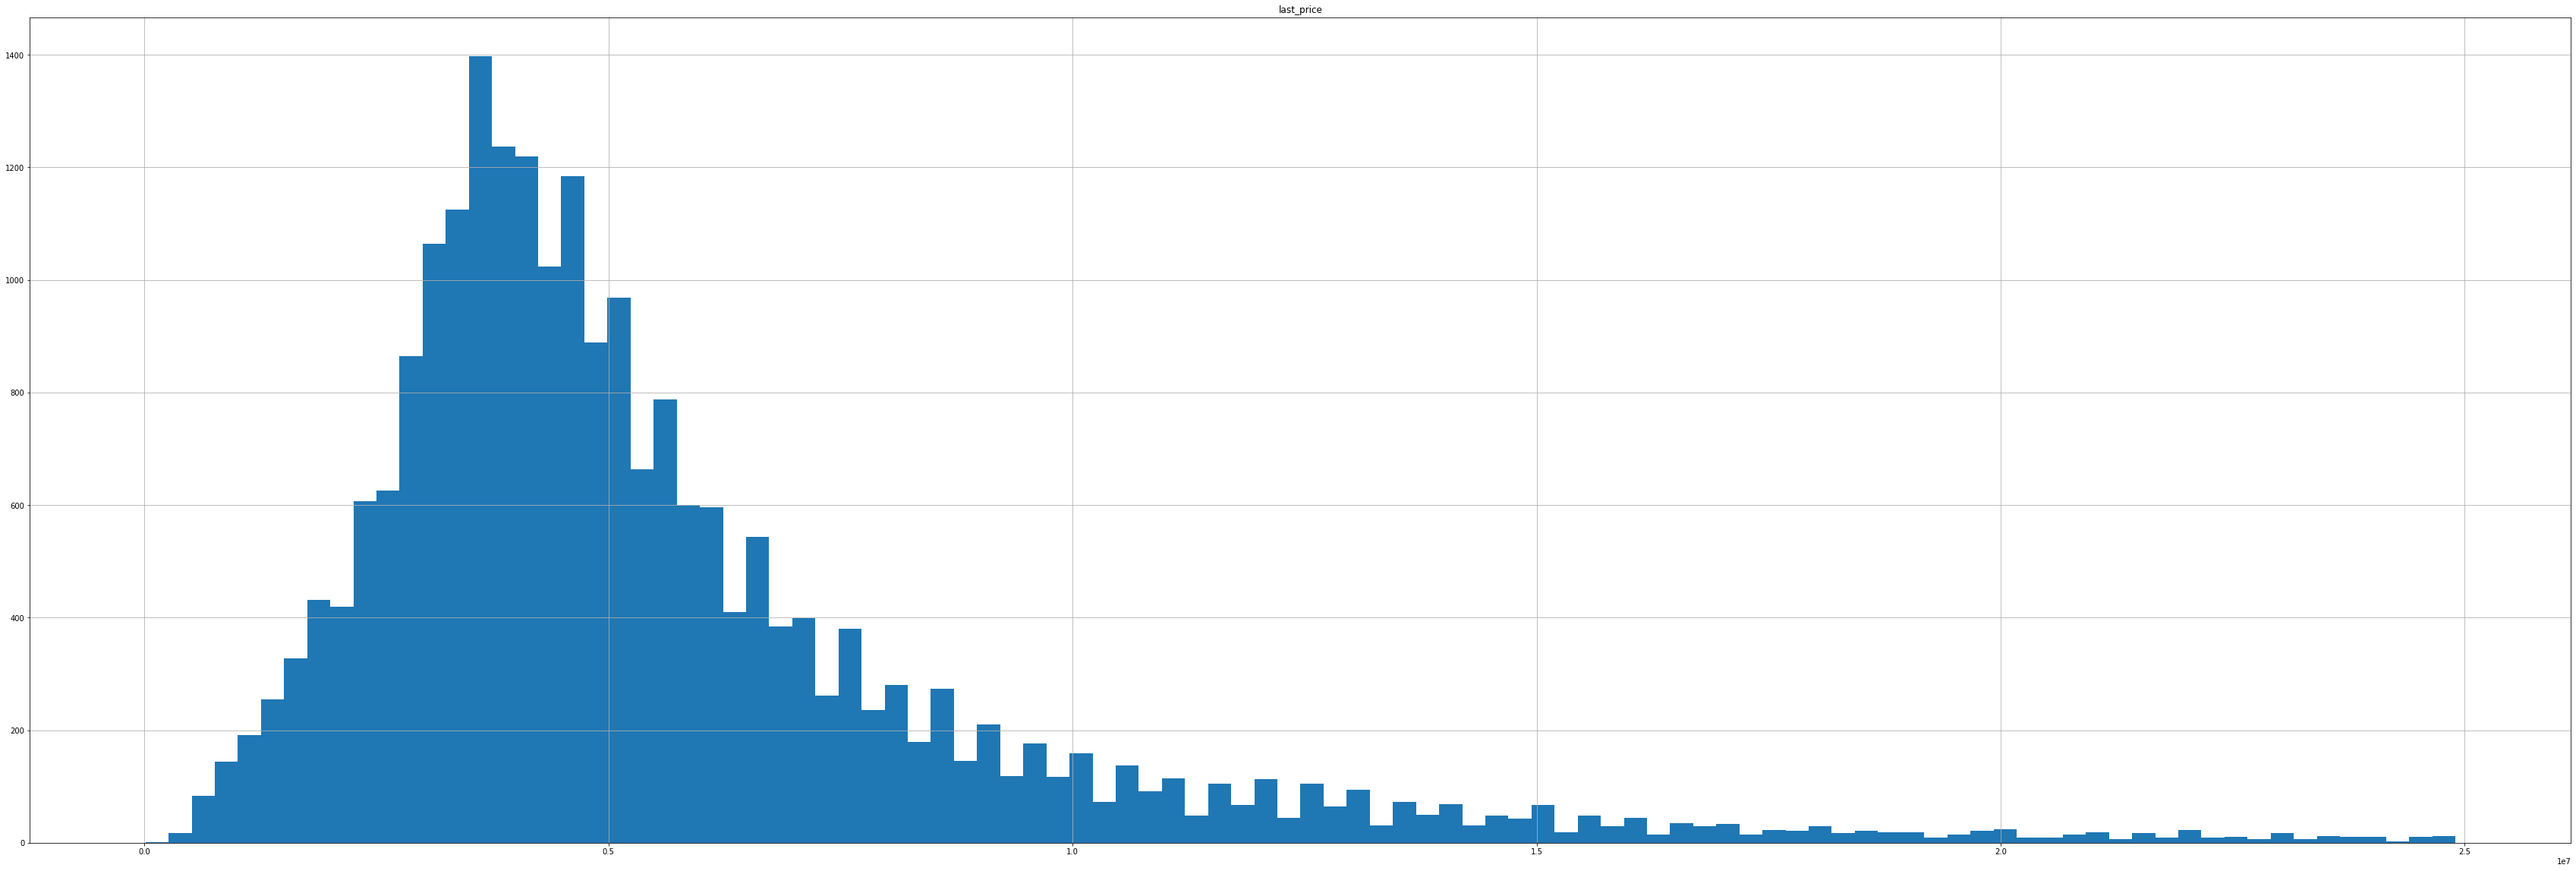

In [28]:
df.loc[df['last_price']<25*10**6].hist('last_price', bins = 100, figsize = (60, 20))

The distribution looks good, we can remove the labelled data.

In [29]:
df = df.loc[df['last_price']<25*10**6]

The distribution of flat values cannot start from values close to 0. We see that the minimum value corresponds to 12,190, which is highly improbable for St. Petersburg, if we consider that all prices are not in currency, it is reasonable to assume that it is thousands of rubles. Let's multiply extremely small values by 1000, such ads will be better filtered by cost per square metre.

<AxesSubplot:>

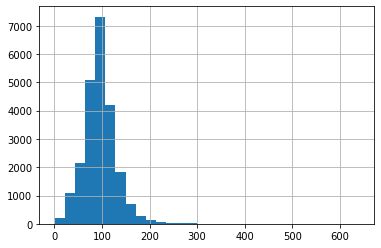

In [30]:
df['square_metr_price'] = df['last_price']/df['total_area']/1000
df['square_metr_price'].hist(bins=30)

We see that most of the values lie between 50 and 150 thousand rubles per square metre, we scale the graph to see the implausible values, if we divide the boundaries of normal distribution by 1000, we get 0.05 and 0.15, in other words, the value we are looking for will be negligible.

<AxesSubplot:>

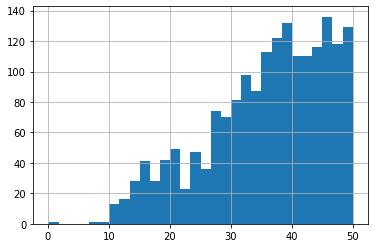

In [31]:
df.loc[df['square_metr_price']<50, 'square_metr_price'].hist(bins=30)

On the graph we see this small peak near zero, let's study it.

In [32]:
print(df.loc[df['square_metr_price']<15])

       total_images  last_price  total_area first_day_exposition  rooms  \
268               7    650000.0        46.0           2018-03-15      2   
3054             20    900000.0        61.4           2018-02-03      3   
3889              4    710000.0        47.7           2018-07-08      2   
4112              9    790000.0        61.0           2018-04-02      3   
4405              9    500000.0        52.0           2018-08-02      2   
4659              1   1650000.0       115.0           2019-02-28      5   
4694             11    950000.0        66.6           2017-10-26      3   
5061              6    900000.0        62.0           2016-04-03      3   
5698              7    450000.0        42.0           2017-07-31      2   
6859              6    490000.0        40.0           2017-12-11      1   
7123              6    790000.0        54.0           2017-11-08      3   
7583              4    850000.0        58.8           2017-09-27      2   
7962              4    55

From the whole dataset we see 1 object whose price is specified in thousand rubles - 8793 or the object with the minimum cost.

In [33]:
df.loc[8793, 'last_price'] = df.loc[8793, 'last_price']*1000

The histogram of ceiling heights looks implausible, because the ceiling height can hardly exceed 4 metres. 
Let's study the values of ceiling heights over 4 metres.

In [34]:
print(df.loc[df['ceiling_height']>4, 'ceiling_height'].value_counts())

4.20      9
27.00     8
25.00     7
4.50      6
8.00      3
4.10      2
32.00     2
4.19      2
4.40      1
8.30      1
5.30      1
4.25      1
5.80      1
4.80      1
100.00    1
4.30      1
4.14      1
14.00     1
22.60     1
10.30     1
5.00      1
4.37      1
4.15      1
26.00     1
4.06      1
4.70      1
27.50     1
24.00     1
20.00     1
Name: ceiling_height, dtype: int64


For many values the substitution is obvious, in other cases we replace with the median.

In [35]:
df['ceiling_height'] = (df['ceiling_height'].replace(
[27, 25, 32, 22.6, 26, 27.5, 24, 20, 8, 8.30, 100, 14, 10.3],
[2.7, 2.5, 3.2, 2.26, 2.6, 2.75, 2.4, 2, 2.65, 2.65, 2.65, 2.65, 2.65]
))

Also from the data above we can see that the minimum ceiling height is 1 metre, let's make a new histogram and see what data needs to be processed.

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

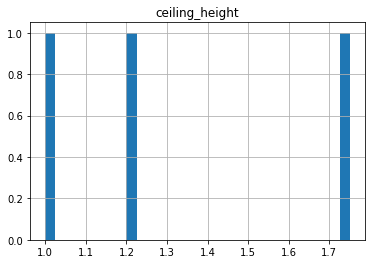

In [36]:
df[df['ceiling_height']<2].hist('ceiling_height', bins=30)

Let's replace indicators 1 and 1.2 with the median value.

In [37]:
df['ceiling_height'] = (df['ceiling_height'].replace(
[1, 1.2],
[2.65, 2.65]
))

When the kitchen is big it's great, but a 100 square kitchen is questionable, first let's update the histogram and see if the distribution has changed.

<AxesSubplot:>

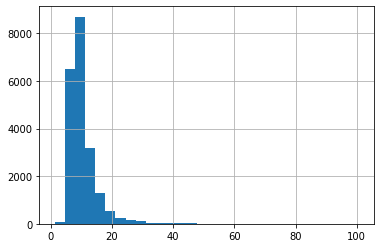

In [38]:
df['kitchen_area'].hist(bins=30)

The kitchen can be connected to the dining room, and judging by the chart of values beyond 45 metres there are few, let's explore them.

In [39]:
print(df.loc[(df['kitchen_area']>40) | (df['kitchen_area']<4),'kitchen_area'].describe())
print(round(df.loc[(df['kitchen_area']>40) | (df['kitchen_area']<4),'kitchen_area'].shape[0]/df.shape[0]*100, 2))

count     95.000000
mean      34.457789
std       22.512735
min        1.300000
25%        3.500000
50%       42.800000
75%       47.500000
max      100.700000
Name: kitchen_area, dtype: float64
0.41


95 extreme values or 0.41%, we can cut them off.

In [40]:
df = df.drop(index = df.loc[(df['kitchen_area']>40) | (df['kitchen_area']<4) & (~df['kitchen_area'].isna()), 'kitchen_area'].index)

In [41]:
low_percentele = 0.01
hihg_percentele = 0.99

last_price_low = df['last_price'].quantile(low_percentele)
last_price_high = df['last_price'].quantile(hihg_percentele)

print(f'Нижняя граница last_price {last_price_low}')
print(f'Верхняя граница last_price {last_price_high}')

print(
    'Процент отброшенных значений = ',
    round(
        100 - len(df.query('@last_price_low <= last_price <= @last_price_high'))
        / len(df['last_price']) * 100,
        2
    ),
    '%'
)

Нижняя граница last_price 1000000.0
Верхняя граница last_price 19800000.0
Процент отброшенных значений =  1.95 %


The total area of the flat is 800 m it is possible but it is an extreme value and we need to remove it, for a start we will update the histogram and see if the distribution has changed

<AxesSubplot:>

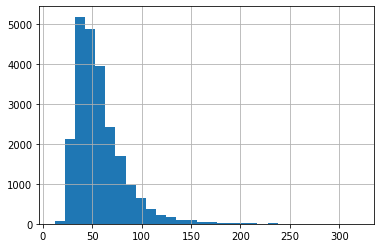

In [42]:
df['total_area'].hist(bins=30)

Let's examine the statistics for facilities over 175 metres.

In [43]:
df.loc[(df['total_area']>175) | (df['total_area']<25),'total_area'].describe()

count    300.000000
mean      97.022133
std       94.897686
min       12.000000
25%       22.500000
50%       24.000000
75%      191.425000
max      320.000000
Name: total_area, dtype: float64

We will remove objects over 200 metres less than 25 square metres.

In [44]:
df = df.loc[(df['total_area']<175) & (df['total_area']>25)]

Let's process the null values in the value of rooms, it is clearly either studios or apartments, we can change 0 to 1. Let's confirm our guess with the total area, if the area will correspond to a 1-room flat, we can change 0 to 1.

count    118.000000
mean      30.504915
std        9.543645
min       25.200000
25%       27.000000
50%       28.000000
75%       30.450000
max       98.400000
Name: total_area, dtype: float64


<AxesSubplot:>

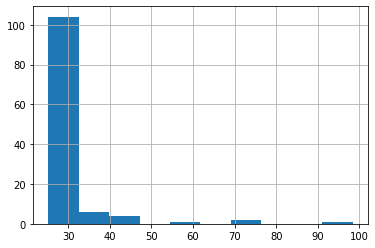

In [45]:
print(df.loc[df['rooms']==0, 'total_area'].describe())
df.loc[df['rooms']==0, 'total_area'].hist()

We see 4 values that are out of our logic, in these lines we will replace 0 with 2 and 3, in other cases we will replace 0 with 1.

In [46]:
df.loc[(df['rooms']==0) & (df['total_area']<50), 'rooms'] = 1
df.loc[(df['rooms']==0) & (df['total_area']<80), 'rooms'] = 2
df.loc[(df['rooms']==0), 'rooms'] = 3

Most of the implicit duplicates were distinguished by e and f, and next time, to save time, you should first replace all f's with f's and then look for duplicates. It is also interesting that data can be wrong at both ends. It is easier to analyse some data through others, so it is much more revealing. In general, the data are very heterogeneous and from the point of view of further work with the data it is better to divide them into SPB and Leningrad region.

### Count and add new columns to the table

We have already added a column with the cost per square metre, now we need to update the data in it.

<AxesSubplot:>

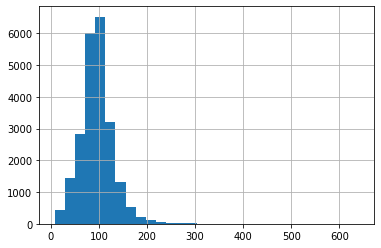

In [47]:
df['square_metr_price'] = df['last_price']/df['total_area']/1000
df['square_metr_price'].hist(bins=30)

We have already worked out the tail with the cheapest square metre, let's look at the statistics of apartments with a square metre of over 200.

In [48]:
df.loc[df['square_metr_price']>200,'square_metr_price'].describe()

count    188.000000
mean     239.283441
std       46.751186
min      200.000000
25%      210.806123
50%      223.570355
75%      254.580153
max      640.422350
Name: square_metr_price, dtype: float64

Only 167 extra-expensive properties, we can donate them

In [49]:
df = df.loc[df['square_metr_price']<300]

Add day of the week, month, year.

In [50]:
df['day'] = df['first_day_exposition'].dt.dayofweek
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year
print(df[['first_day_exposition','day', 'month', 'year']].head())

  first_day_exposition  day  month  year
0           2019-03-07    3      3  2019
1           2018-12-04    1     12  2018
2           2015-08-20    3      8  2015
5           2018-09-10    0      9  2018
6           2017-11-02    3     11  2017


Add the floor type

In [51]:
df['floor_type'] = np.nan
df.loc[df['floor'] == df['floors_total'], 'floor_type']= 'Последний'
df.loc[df['floor'] == 1, 'floor_type'] = 'Первый'
df['floor_type'].fillna('Другой', inplace = True)
print(df['floor_type'].value_counts())

Другой       16692
Последний     3183
Первый        2831
Name: floor_type, dtype: int64


Let's translate the distance to the city centre into km.

In [52]:
df['cityCenters_nearest'] = round(df['cityCenters_nearest']/1000,0)
df['cityCenters_nearest'].head()

0    16.0
1    19.0
2    14.0
5     NaN
6    19.0
Name: cityCenters_nearest, dtype: float64

### Do an exploratory analysis of the data

#### Common Area Analysis.

<AxesSubplot:>

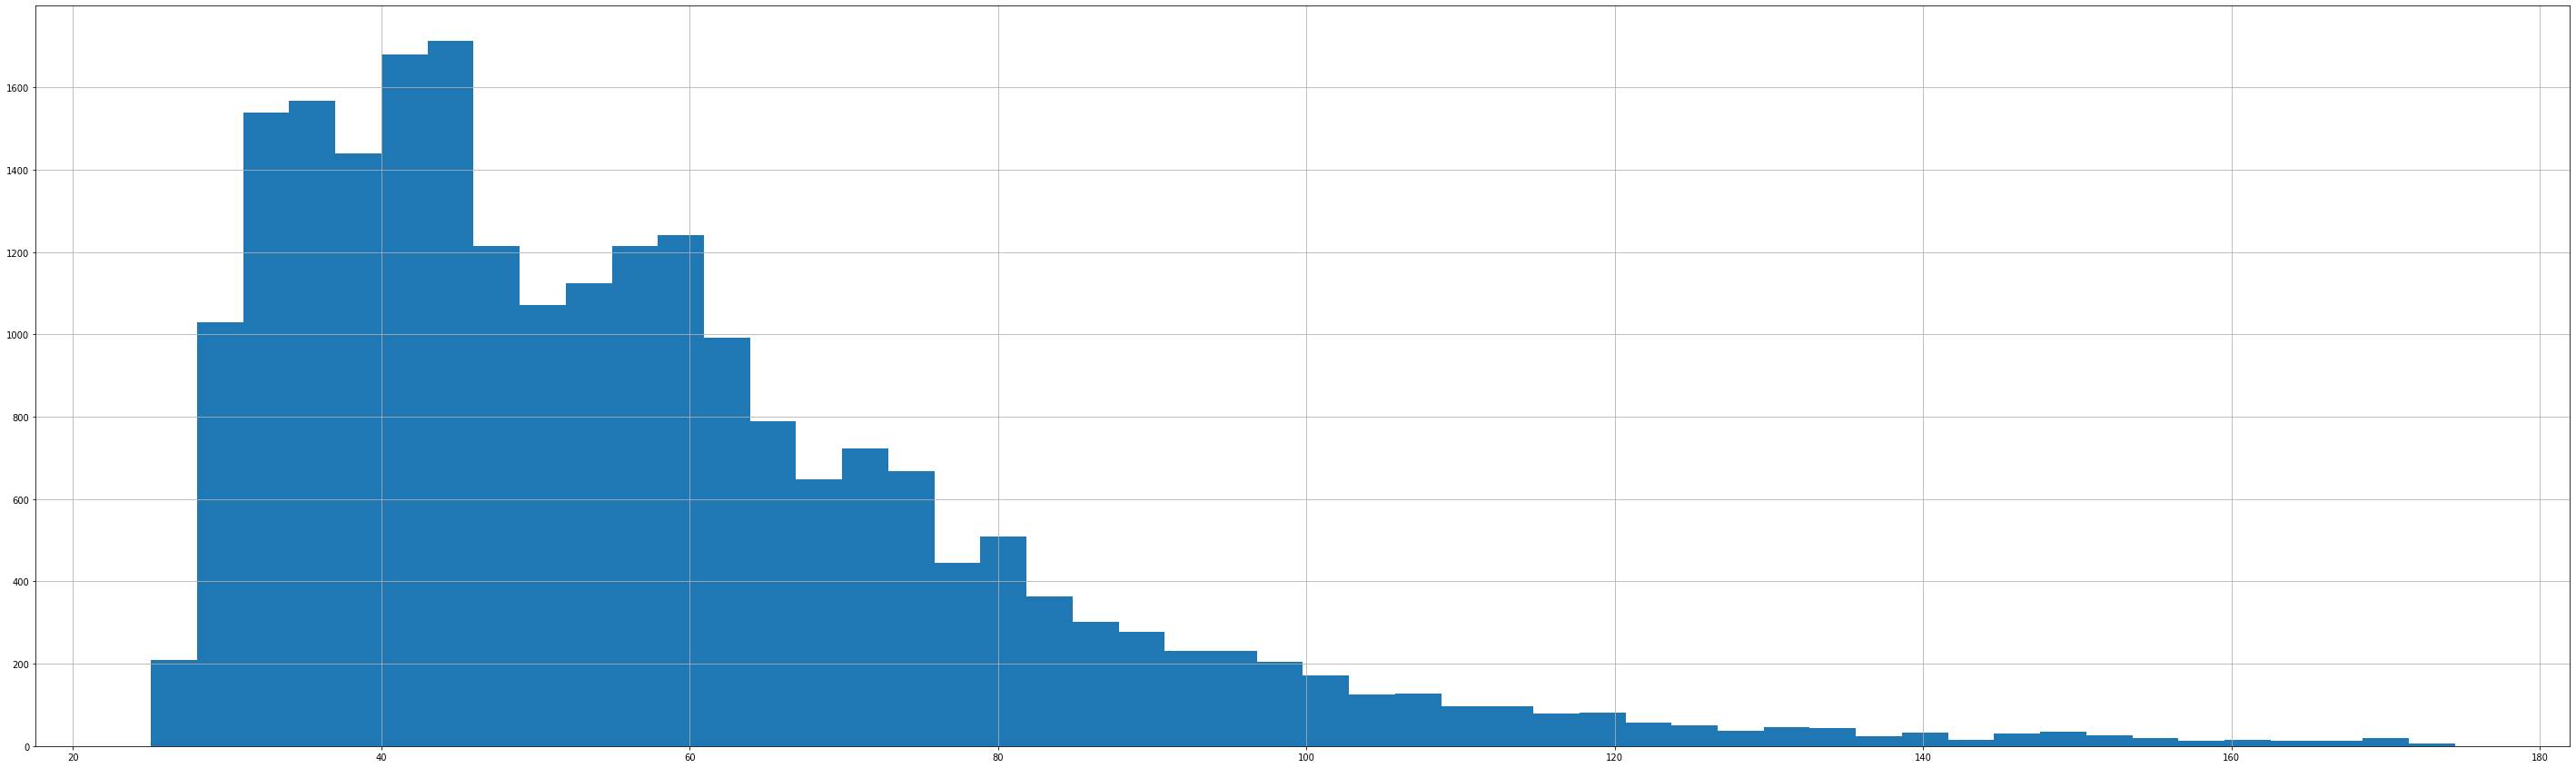

In [53]:
df['total_area'].hist(bins = 50, figsize = (50,15))

On the histogram we see 3 peaks in the area of 35 square metres, 48 square metres and 60 square metres, this corresponds to the distribution of the number of rooms, we can safely say that the area directly correlates with the price, let's confirm it.

In [54]:
print(df[['total_area', 'last_price']].corr())

            total_area  last_price
total_area    1.000000    0.777517
last_price    0.777517    1.000000


We see a strong correlation coefficient, but blurred due to the difference in the cost per square metre in SPD and Leningrad Oblast.

In [55]:
print(df.loc[df['locality_name'] == 'Санкт-Петербург', ['total_area', 'last_price']].corr())

            total_area  last_price
total_area    1.000000    0.823512
last_price    0.823512    1.000000


Isolated for SPB, the correlation coefficient is significantly higher. We can also safely say that the total area will also correlate with such indicators as living area, kitchen area, number of rooms and balconies.
Let's evaluate the statistical data of this indicator

In [56]:
print(df['total_area'].describe())

count    22706.000000
mean        56.828178
std         23.222469
min         25.070000
25%         40.000000
50%         51.200000
75%         67.600000
max        174.500000
Name: total_area, dtype: float64


Most of the values are in the narrow range between 40 and 67 metres, which indeed corresponds to the area of an average flat. The median and mean values are close, although the influence of the long tail is still noticeable in the mean value.

#### Analysis of living space.

<AxesSubplot:>

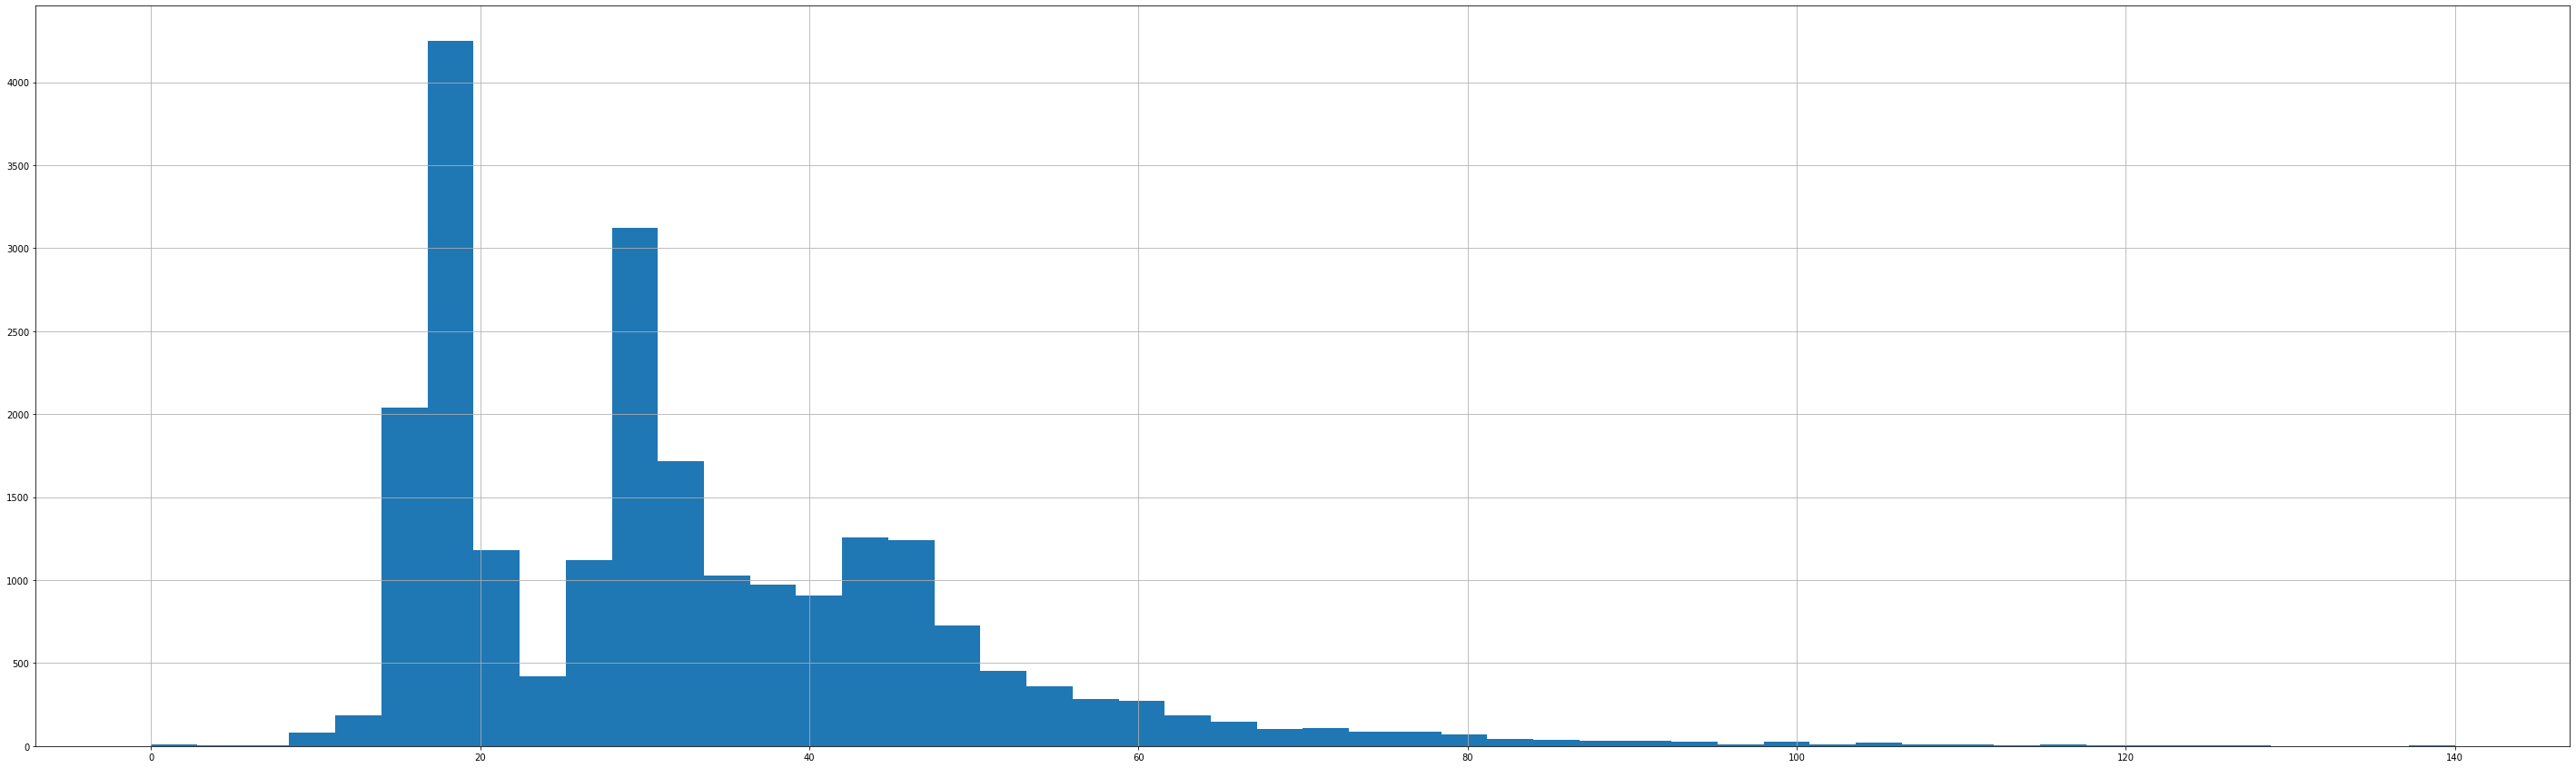

In [57]:
df['living_area'].hist(bins = 50, figsize = (50,15))

The graphs are similar to the total area, but the histogram of the living area shows more clearly the peaks of multi-room flats. We can still say that there is a relationship between living space and flat prices, but the relationship is much weaker than for the total area. The existence of such a relationship is rather conditioned by the existence of a relationship between the total area and the living area.

In [58]:
print(df[['total_area', 'last_price', 'living_area']].corr())

             total_area  last_price  living_area
total_area     1.000000    0.777517     0.913614
last_price     0.777517    1.000000     0.641820
living_area    0.913614    0.641820     1.000000


Let's examine the statistics.

In [59]:
print(df['living_area'].describe())

count    22706.000000
mean        32.452029
std         15.716770
min          0.000000
25%         18.400000
50%         30.000000
75%         41.900000
max        140.000000
Name: living_area, dtype: float64


In terms of statistical distribution we can see a picture very close to the total area statistic, and this is not surprising as the relationship between these two indicators is very strong, we can also see 0's and a small number of near-zero values, these are most likely unrecorded data or outliers, but as the living area indicator is not of key importance, the data was left in.

#### Analysing kitchen areas.

<AxesSubplot:>

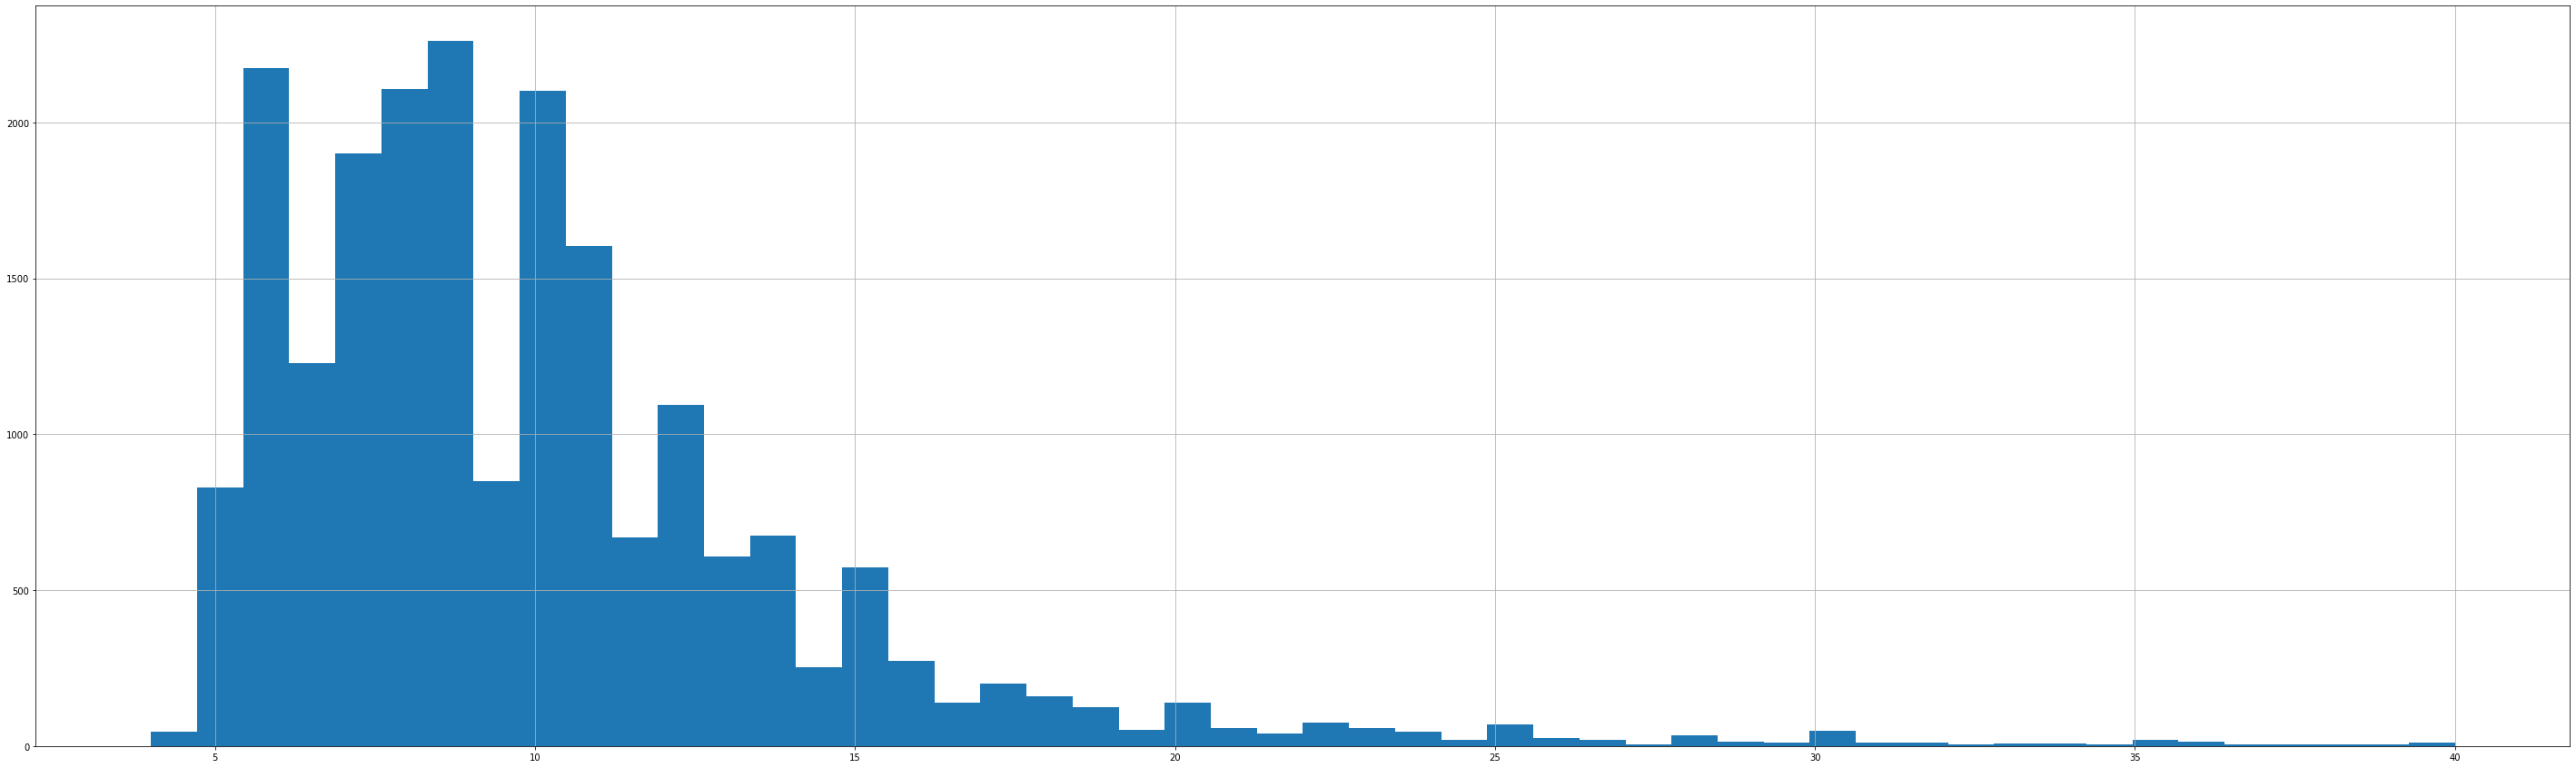

In [60]:
df['kitchen_area'].hist(bins = 50, figsize = (50,15))

We see several peaks on the chart, which can be interpreted as some housing development patterns. In some times it was customary to build houses with kitchens of 6 metres, in some times 8 metres, plus the number of rooms is also a factor. It is difficult to speak about correlations in this case, there is a mutual correlation between the difference of the total area and living area and the kitchen area, but this correlation is logical and follows from the very definition of the concepts. Let's take a look at the statistical data.

In [61]:
df['kitchen_area'].describe()

count    20698.000000
mean        10.072551
std          4.389013
min          4.000000
25%          7.000000
50%          9.000000
75%         11.600000
max         40.000000
Name: kitchen_area, dtype: float64

The average is close to the median, but the influence of the long tail is felt, most values are in a narrow range from 7 to 11.5 metres, we can say that the data is valid. We can also see about 2 thousand broken values, we can say that most of them are missing separate kitchens, i.e. flats like studios or eurodvushki, but probably there is also a large share of ads in which people simply did not specify the area, so we will not replace them with zeros.

#### Analysing the price of an object.

<AxesSubplot:>

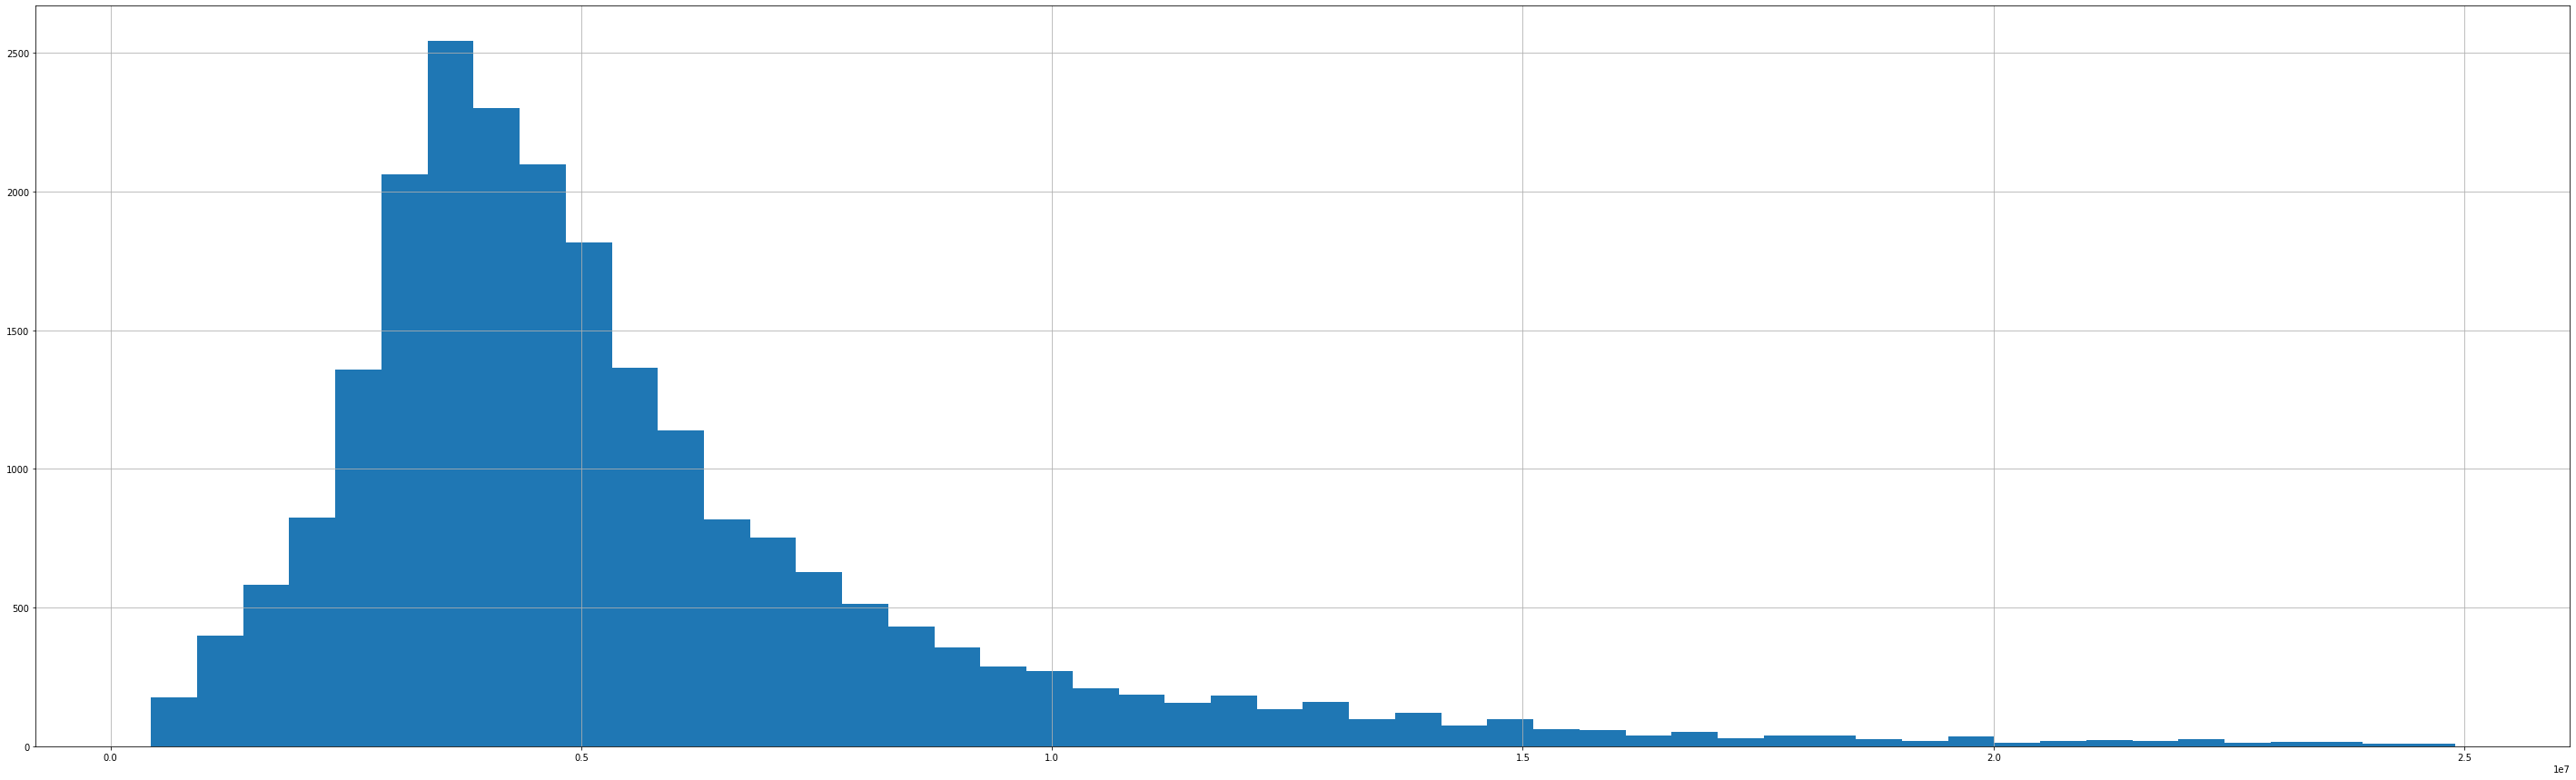

In [62]:
df['last_price'].hist(bins = 50, figsize = (50,15))

It's beautiful, what else can I say)))))) One smoothly gained peak, with a smooth fall in price sliding to a point, the only thing is that the scale is logarithmic, but you can work with it. We can say that the price is directly correlated with the area and location, the price of property in St. Petersburg will be much higher than in the villages of Len region. We have proved the direct correlation between price and area above. Other factors such as living area, balconies, kitchen area, floor type, number of parks, etc. will certainly be influential, but it would be incorrect to correlate between them. To assess the impact of these factors, it is more appropriate to correlate the above criteria to the cost per square metre.

In [63]:
df['last_price'].describe()

count    2.270600e+04
mean     5.506275e+06
std      3.409719e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.500000e+06
max      2.490000e+07
Name: last_price, dtype: float64

In the statistical indicators we see a big gap between the median and the average, this is due to the fact that in St. Petersburg there is a large number of properties with expensive square metres and this is an important market segment. Meanwhile, the majority of volumes are in the range from 3.4 to 6.5 million, but this is a significant influence of properties in the Leningrad region.

#### Analysing the number of rooms.

<AxesSubplot:>

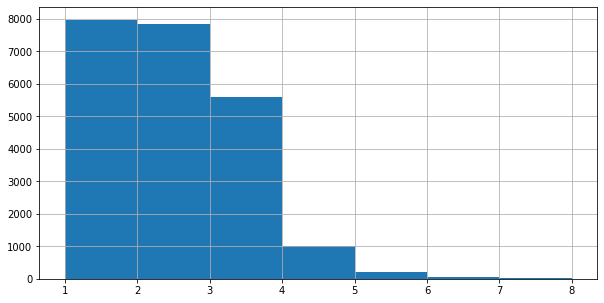

In [64]:
df['rooms'].hist(bins = 7, figsize = (10,5))

We see that about one third of flats are one-room and one third are two-room, the two most popular types of flats. Approximately 70% of the flats from the last third are three-room flats, further the number of 4-room and more types of flats decreases sharply.

#### Analysing ceiling heights.

<AxesSubplot:>

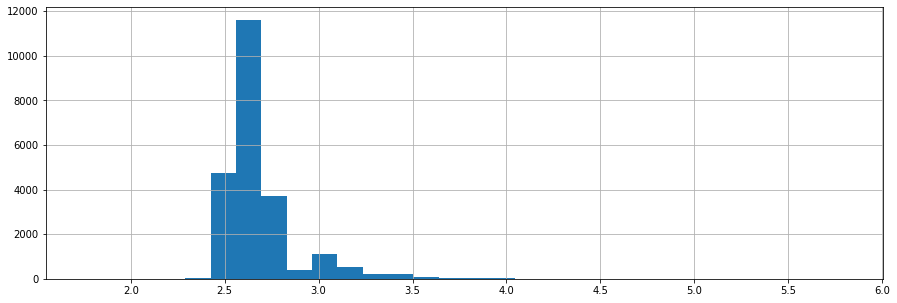

In [65]:
df['ceiling_height'].hist(bins = 30, figsize = (15,5))

On the histogram we see a very narrow dome, 95% of all values are concentrated in a small range. We also see a small peak in the area of values around 3 metres, this is also related to construction patterns.

In [66]:
df['ceiling_height'].describe()

count    22706.000000
mean         2.686689
std          0.202519
min          1.750000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.800000
Name: ceiling_height, dtype: float64

Statistically, we see that the interquartile range is only 10 centimetres, and the mean differs from the median by only 3. Such data are natural, because the ceiling height is quite a stable value.

#### Анализ этажа в объявлении.

<AxesSubplot:>

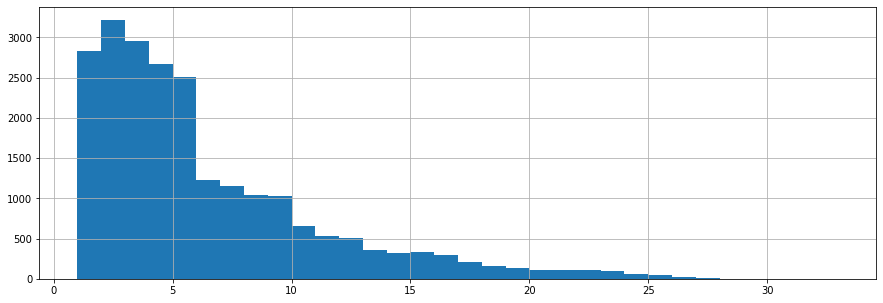

In [67]:
df['floor'].hist(bins = 32, figsize = (15,5))

We can see that the bulk of adverts for sale of flats on the 1st-5th floors, it is logical, because most of the houses are 5-storey buildings. We also see that the number of adverts for sale of flats on the 1st floor is slightly less than on the second floor, and this is also logical, because the ground floors are more often given for commerce.

In [68]:
df['floor'].describe()

count    22706.000000
mean         5.876376
std          4.865520
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

As for the statistics, it confirms that St Petersburg and the Leningrad region in its mass have a fairly low build-up rate.

#### Analysing the total number of floors.

<AxesSubplot:>

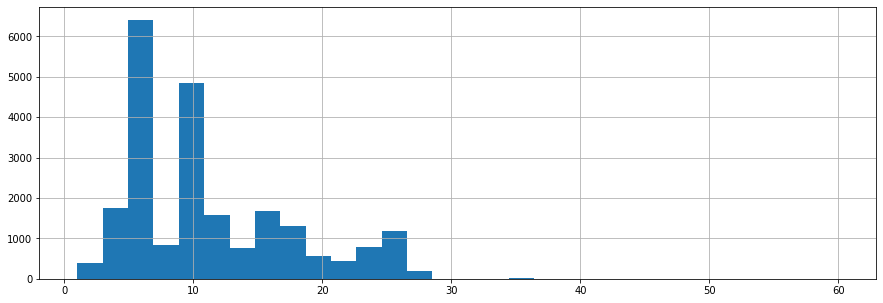

In [69]:
df['floors_total'].hist(bins = 30, figsize = (15,5))

We see two pronounced peaks of about 5 and about 10 (or rather 9) storeys, which can also be explained by construction patterns. Plus, let's not forget that most of St. Petersburg is a historical building, which was built in those times when 5 storeys was the pinnacle of construction skills.

In [70]:
df['floors_total'].describe()

count    22706.000000
mean        10.716066
std          6.595276
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

#### Floor Type Analysis.

<AxesSubplot:>

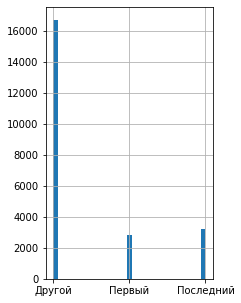

In [71]:
df['floor_type'].hist(bins = 33, figsize = (3,5))

As expected, the absolute majority of adverts for sale are not on the first or the last floor. We also see that the number of ads for sale on the 1st floor is less than on the last floor, this phenomenon we have analysed above.

In [72]:
df['floor_type'].describe()

count      22706
unique         3
top       Другой
freq       16692
Name: floor_type, dtype: object

#### Analysis of distance to the city centre.

This indicator has a very large number of missing values, to begin with we need to test the theory that this indicator is only specified for SPB.

In [73]:
print(df.loc[(df['locality_name'] != 'Санкт-Петербург') & (~df['cityCenters_nearest'].isna()), 'locality_name'].shape)

(2442,)


No, the theory is not justified, but perhaps this indicator is determined in only a couple of cities except for St. Petersburg.

In [74]:
print(df.loc[(df['locality_name'] != 'Санкт-Петербург') & (~df['cityCenters_nearest'].isna()), 'locality_name'].value_counts())

посёлок Шушары             430
Пушкин                     355
Колпино                    335
посёлок Парголово          325
Петергоф                   200
Сестрорецк                 181
Красное Село               174
Ломоносов                  132
Кронштадт                   95
посёлок Металлострой        66
посёлок Стрельна            41
Павловск                    37
Зеленогорск                 22
посёлок Понтонный           20
посёлок Сапёрный             6
посёлок Молодёжное           5
посёлок Песочный             4
посёлок Лисий Нос            3
посёлок Репино               3
посёлок Мурино               2
посёлок Усть-Ижора           2
посёлок Петро-Славянка       1
посёлок Левашово             1
посёлок Александровская      1
посёлок Белоостров           1
Name: locality_name, dtype: int64


No there are many such cities, it is interesting to see if the distance is given as local centre or peter city centre.

<AxesSubplot:>

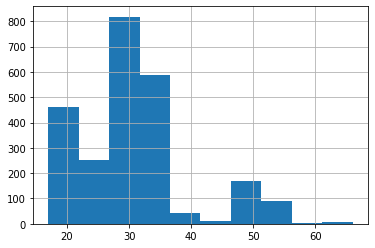

In [75]:
df.loc[(df['locality_name'] != 'Санкт-Петербург') & (~df['cityCenters_nearest'].isna()), 'cityCenters_nearest'].hist()

The minimum value is 20km, which is more than the radius of any village, still looks like the distance to the centre of SPB.

<AxesSubplot:>

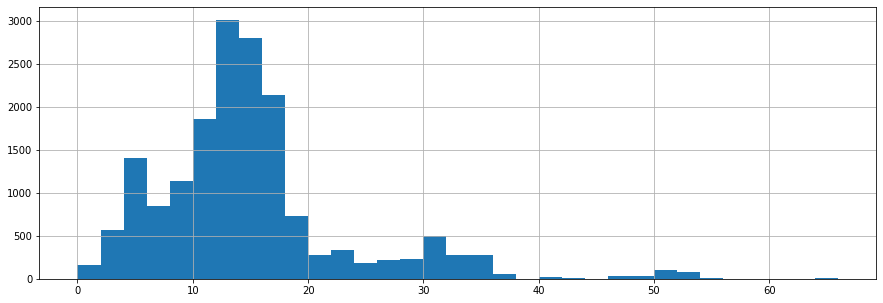

In [76]:
df['cityCenters_nearest'].hist(bins = 33, figsize = (15,5))

Based on the analysis above, we can make the assumption that SPB ends at 20 km from the city centre, our new graph confirms our theory, as we see a sharp decrease in the number of ads after 20 km, and SPB is the leader in terms of ads, then the density of building and the frequency of calculation of the index decreases. It is interesting that we see another peak around 5 km, perhaps this is due to the development of multi-storey neighbourhoods.

In [77]:
df['cityCenters_nearest'].describe()

count    17336.000000
mean        14.478369
std          8.583817
min          0.000000
25%         10.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: cityCenters_nearest, dtype: float64

#### Airport Distance Analysis.

The distance to the airport will be visualised in km as well.

<AxesSubplot:>

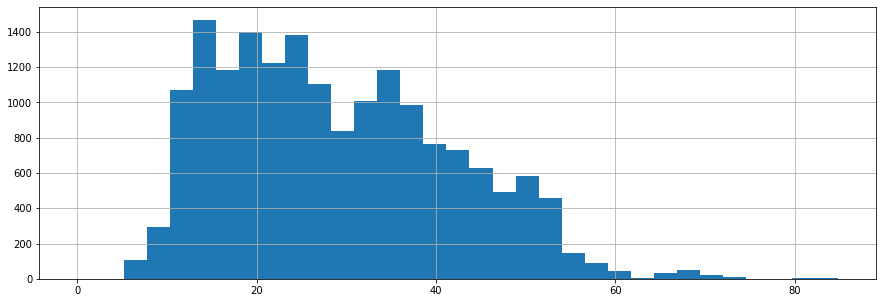

In [78]:
df_air = df['airports_nearest']/1000
df_air.hist(bins = 33, figsize = (15,5))

Based on the assumption, from the previous analysis, that the borders of St. Petersburg are 20 km from the centre, we can conclude that the airport is about 30 km from St. Petersburg and 10 km from its border, because the concentration of ads at a distance of 10 to 50 km, as well as we see a drawdown at a distance of 30 km, which would correspond to the centre itself, where the smallest number of ads.

#### Park Distance Analysis.

The distance to the park will also be visualised in km.

<AxesSubplot:>

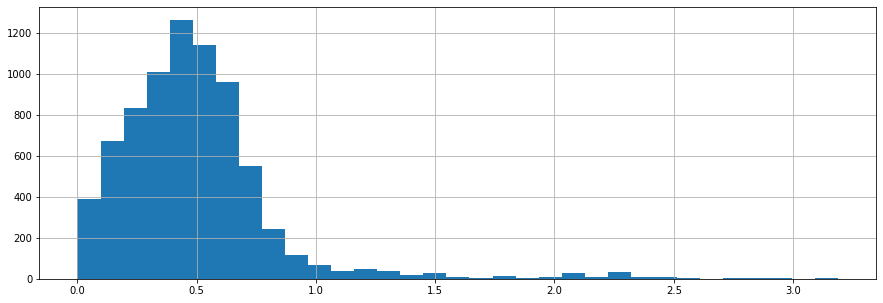

In [79]:
df_park = df['parks_nearest']/1000
df_park.hist(bins = 33, figsize = (15,5))

Well, it looks like there are plenty of parks in SPB, so that on average every house has a park within half an hour's walk, and the owners of those 400 flats that are 100 metres from the nearest park are also very lucky. In general, we see a normal distribution, showing that the concentration of parks in SPB is about 1 per 1.5 - 2 square kilometres.

#### Analysing the day of publication.

<AxesSubplot:>

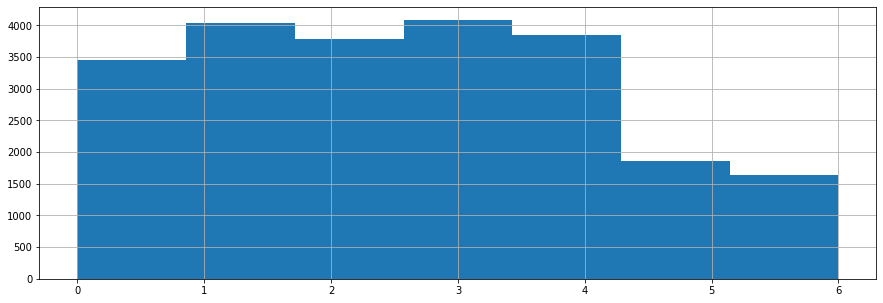

In [80]:
df['day'].hist(bins = 7, figsize = (15,5))

It seems that on weekends people prefer to rest rather than sell flats. Perhaps it is also connected with the weekend at realtors. During the working week the distribution is quite even, except for Monday, but as we know Monday is a hard day.

#### Analysing the month of publication.

<AxesSubplot:>

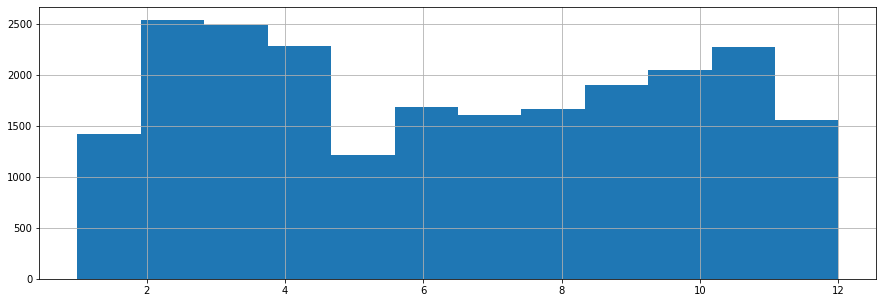

In [81]:
df['month'].hist(bins = 12, figsize = (15,5))

On the graph of activity by month we see a strong influence of May and New Year holidays, the time when you don't want to think about property transactions. We also see a peak in February, March, April, as well as a growing interest in property transactions from September to November. Most likely, if it were not for the New Year frenzy, we would see a smooth chart with a slump in the summer months, when everyone is on holiday, at the cottages, etc. and not to flats. And a peak in the winter months, when people have free time.

Examine how quickly the flats sold

count    19725.000000
mean       178.723752
std        217.060323
min          1.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

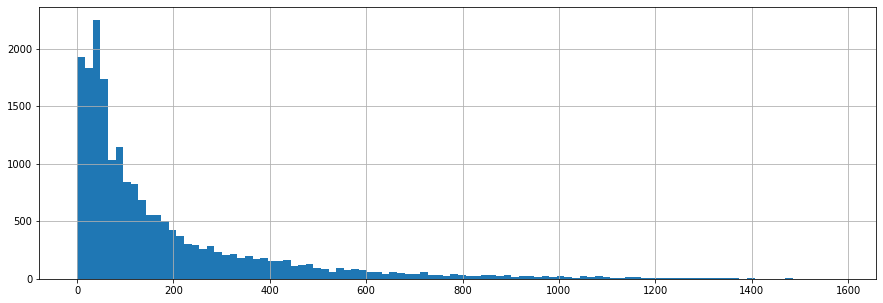

In [82]:
df['days_exposition'].hist(bins = 100, figsize = (15,5))
df['days_exposition'].describe()

In the graph we see that most of the sales are made in a fairly short period of time. We can see that the number of sold flats after 60 days decreases sharply. It is also possible that people after a short period of posting an ad re-post it with new photos, etc. Judging by statistical data we see that a quarter of flats are sold within 45 days, based on this figure we can assume that a quick sale can be considered 10 - 15 days. Half of the apartments are sold within 94 days, this figure can be considered a normal sale period. I think a long sale can be considered to be over the 3rd quartile or longer than 228 days.

What factors influence the total (full) value of the object most of all?
I have already written above that it is incorrect to assess the influence of factors other than the total area on the total cost, to prove this judgement, let's conduct a mental experiment that Einstein loved so much.
Let's take two hypothetical flats, they are in the same house on the same floor, but one of them is one without a balcony, the second three with a balcony, one costs 4.5 million three 9.3 million, with one 35 squares, three 70.
Our data is quite plausible, so we can rely on it.
If we calculate the correlation between the presence of a balcony and the total cost, it turns out that the presence of a balcony increases the price of the flat by 4 million.
I realise on big data it won't look like that, but the error remains.
But if we exclude the main influencing factor area, the values will be equilibrium, and on such data we can study the correlation.

#### Analysing the correlation between the total floor area and the value of the property

The analysis of how the total area affects the final price has been done above, the correlation is strong, positively directed. In general, it is expected that the more square metres you buy, the more you pay. The rest of the analysis will be carried out to the price per square metre to exclude the factor of area.

            total_area  last_price
total_area    1.000000    0.823512
last_price    0.823512    1.000000
            total_area  last_price
total_area    1.000000    0.777517
last_price    0.777517    1.000000


<AxesSubplot:xlabel='last_price', ylabel='total_area'>

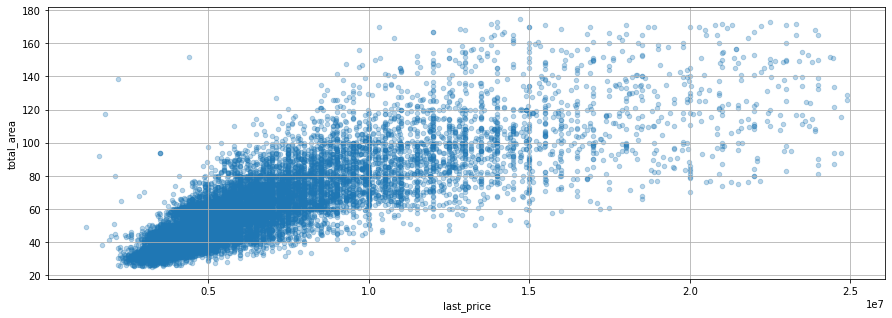

In [83]:
print(df.loc[df['locality_name'] == 'Санкт-Петербург',['total_area', 'last_price']].corr())
print(df[['total_area', 'last_price']].corr())
df.loc[df['locality_name'] == 'Санкт-Петербург',['total_area', 'last_price']].plot(kind = 'scatter', 
                                                         x = 'last_price', 
                                                         y = 'total_area', 
                                                         figsize = (15,5),
                                                         grid = True,
                                                        alpha = 0.3)

We see that the strongest dependence is on small areas, but the larger the area, the less influence this factor has on the final price.

#### Analysing the correlation between living space and property value

The correlation between living area and final price was also analysed above, the correlation is still strong, but weaker than with the total area, which is explained by the strong correlation between the total and living area. What is really interesting is the correlation of the ratio of living space to total area with the price per square metre. It makes sense, because if half of your one-bedroom is a useless corridor, it will probably cost less.

             living_area  last_price
living_area     1.000000    0.687705
last_price      0.687705    1.000000
             living_area  last_price
living_area      1.00000     0.64182
last_price       0.64182     1.00000


<AxesSubplot:xlabel='last_price', ylabel='living_area'>

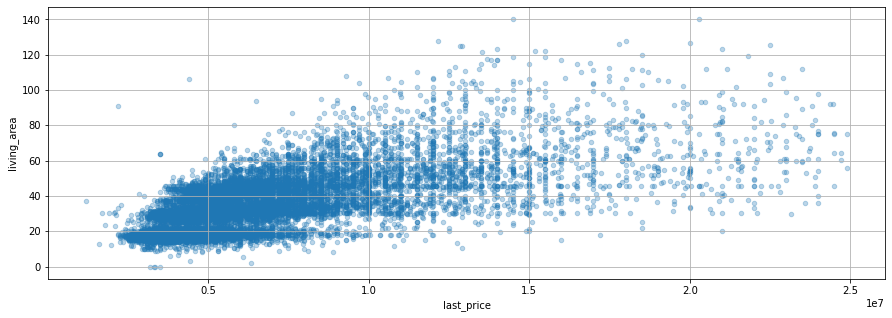

In [84]:
print(df.loc[df['locality_name'] == 'Санкт-Петербург',['living_area', 'last_price']].corr())
print(df[['living_area', 'last_price']].corr())
df.loc[df['locality_name'] == 'Санкт-Петербург',['living_area', 'last_price']].plot(kind = 'scatter', 
                                                         x = 'last_price', 
                                                         y = 'living_area', 
                                                         figsize = (15,5),
                                                         grid = True,
                                                        alpha = 0.3)

We see a similar pattern to the total area distribution graph, which is not surprising since living area is closely related to total area.

Let's calculate the proportion of living space to total floor area.

In [85]:
df['percent_of_living_area'] = df['total_area']/df['living_area']

Let's calculate and visualise the correlation.

                        percent_of_living_area  square_metr_price
percent_of_living_area                1.000000           0.238118
square_metr_price                     0.238118           1.000000
                        percent_of_living_area  square_metr_price
percent_of_living_area                1.000000           0.212388
square_metr_price                     0.212388           1.000000


<AxesSubplot:xlabel='square_metr_price', ylabel='percent_of_living_area'>

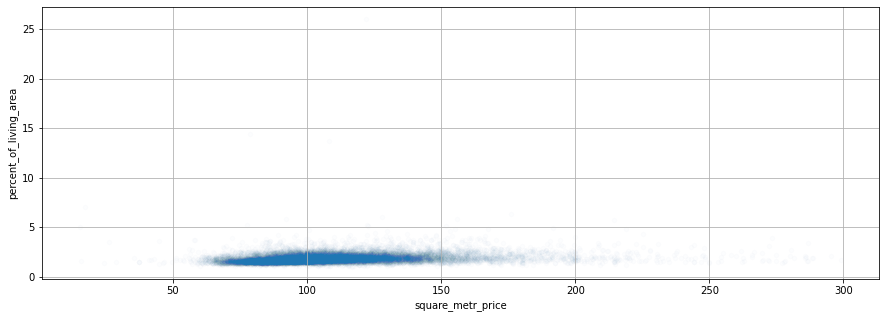

In [86]:
print(df.loc[df['locality_name'] == 'Санкт-Петербург',['percent_of_living_area', 'square_metr_price']].corr())
print(df[['percent_of_living_area', 'square_metr_price']].corr())
df.loc[df['locality_name'] == 'Санкт-Петербург',['percent_of_living_area', 'square_metr_price']].plot(kind = 'scatter', 
                                                         x = 'square_metr_price', 
                                                         y = 'percent_of_living_area', 
                                                         figsize = (15,5),
                                                         grid = True,
                                                        alpha = 0.01)

The correlation coefficient indicates that there is a very weak positive dependence, on the graph the dependence is almost invisible, there may be a very small slope, on the other hand, what can be expected from the secondary parameter.

#### Analysis of the impact of kitchen area on the cost per square metre.

                   kitchen_area  square_metr_price
kitchen_area           1.000000           0.328321
square_metr_price      0.328321           1.000000
                   kitchen_area  square_metr_price
kitchen_area           1.000000           0.334398
square_metr_price      0.334398           1.000000


<AxesSubplot:xlabel='square_metr_price', ylabel='kitchen_area'>

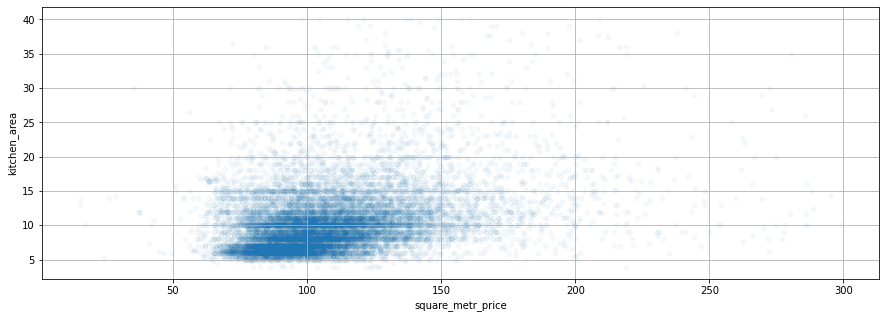

In [87]:
print(df.loc[df['locality_name'] == 'Санкт-Петербург',['kitchen_area', 'square_metr_price']].corr())
print(df[['kitchen_area', 'square_metr_price']].corr())
df.loc[df['locality_name'] == 'Санкт-Петербург',['kitchen_area', 'square_metr_price']].plot(kind = 'scatter',
                                                         x = 'square_metr_price', 
                                                         y = 'kitchen_area', 
                                                         figsize = (15,5),
                                                         grid = True,
                                                        alpha = 0.04)

We see a more significant correlation coefficient, which is also confirmed by the graph, in general we can say that there is a noticeable interdependence.

#### Analysis of the impact of the number of rooms per square metre.

                      rooms  square_metr_price
rooms              1.000000          -0.175502
square_metr_price -0.175502           1.000000
                      rooms  square_metr_price
rooms              1.000000          -0.094967
square_metr_price -0.094967           1.000000


<AxesSubplot:xlabel='rooms'>

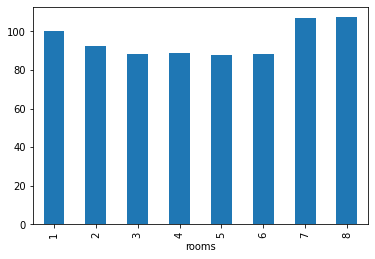

In [88]:
print(df.loc[df['locality_name'] == 'Санкт-Петербург',['rooms', 'square_metr_price']].corr())
print(df[['rooms', 'square_metr_price']].corr())
df.groupby('rooms')['square_metr_price'].median().plot(kind = 'bar')

We can see that there is a very weak inverse relationship

#### Analysing the impact of floor type.

Let's make the floor type change 1 - First, 2 - Other, 3 - Last.

                   floor_type  square_metr_price
floor_type           1.000000           0.148164
square_metr_price    0.148164           1.000000
                   floor_type  square_metr_price
floor_type           1.000000           0.214049
square_metr_price    0.214049           1.000000


<AxesSubplot:xlabel='floor_type'>

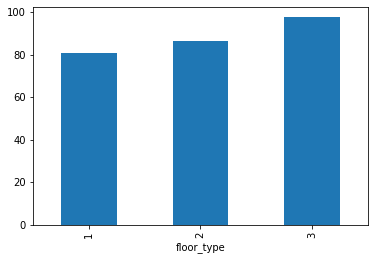

In [89]:
df.loc[df['floor_type'] == 'Первый', 'floor_type'] = 1
df.loc[df['floor_type'] == 'Другой', 'floor_type'] = 3
df.loc[df['floor_type'] == 'Последний', 'floor_type'] = 2
df['floor_type'] = df['floor_type'].astype('int')
print(df.loc[df['locality_name'] == 'Санкт-Петербург',['floor_type', 'square_metr_price']].corr())
print(df[['floor_type', 'square_metr_price']].corr())

df.groupby('floor_type')['square_metr_price'].median().plot(kind = 'bar')

We can see that dependency is virtually non-existent.

#### Analysis of the influence of the date of placement (day of the week, month, year) on the price per square metre.

In [90]:
print(df[['day', 'square_metr_price']].corr())
print(df[['month', 'square_metr_price']].corr())
print(df[['year', 'square_metr_price']].corr())
print(df['year'].unique())

                        day  square_metr_price
day                1.000000          -0.013926
square_metr_price -0.013926           1.000000
                      month  square_metr_price
month              1.000000          -0.003815
square_metr_price -0.003815           1.000000
                       year  square_metr_price
year               1.000000           0.050914
square_metr_price  0.050914           1.000000
[2019 2018 2015 2017 2016 2014]


On the given range of dates it is possible to assert that there is no influence of the date of publication on the cost per square metre.

#### Calculation of the average price per square metre in the 10 settlements with the largest number of advertisements.

                   quontity  square_metr_price
Санкт-Петербург       14942         109.241090
посёлок Мурино          549          85.257717
Кудрово                 443          94.673787
посёлок Шушары          431          78.177360
Всеволожск              392          67.235660
Пушкин                  356         102.161889
Колпино                 336          75.239591
посёлок Парголово       325          90.430721
Гатчина                 307          68.746147
Выборг                  230          57.688216


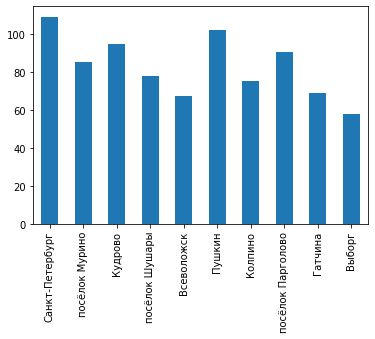

In [91]:
top_region = df['locality_name'].value_counts().nlargest(10)
top_region = pd.merge(left = top_region,
                     right = pd.pivot_table(df,
                                           values = 'square_metr_price',
                                           index = 'locality_name'),
                     how = 'left',
                     left_index = True,
                     right_index = True)
top_region.columns = ['quontity', 'square_metr_price']
top_region['square_metr_price'].plot(kind='bar')
print(top_region)

Expectedly, the most expensive square metre is in St. Petersburg, as apparently Pushkin is either the nearest or rather elite settlement. The cheapest square metre was in Vyborg, Vsevolozhsk and Gatchina.

#### Calculation of the average price of each kilometre of SPB.

In [92]:
square_metr_price_mean = pd.pivot_table(df.loc[df['locality_name'] == 'Санкт-Петербург'],
                                       values = 'square_metr_price',
                                       index = 'cityCenters_nearest')
print(square_metr_price_mean.sort_index())

                     square_metr_price
cityCenters_nearest                   
0.0                         121.462298
1.0                         130.960609
2.0                         126.582252
3.0                         115.067246
4.0                         122.065994
5.0                         127.465242
6.0                         128.284426
7.0                         127.475216
8.0                         122.538833
9.0                         111.089137
10.0                        111.530955
11.0                        107.909103
12.0                        107.325475
13.0                        107.707073
14.0                        103.877096
15.0                        103.765601
16.0                        100.303866
17.0                         96.262458
18.0                         96.081262
19.0                         98.538304
20.0                        101.414915
21.0                         94.509189
22.0                         91.405542
23.0                     

<AxesSubplot:xlabel='cityCenters_nearest'>

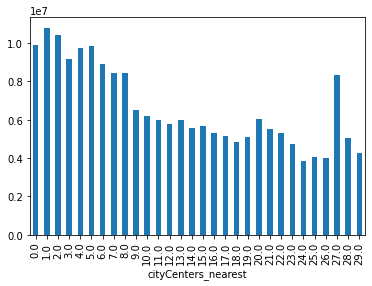

In [93]:
mean_object_price_by_loc = df.loc[df['locality_name'] == 'Санкт-Петербург'].groupby('cityCenters_nearest')['last_price'].mean()
mean_object_price_by_loc.plot(kind = 'bar')

Except for some abnormal jumps, we can observe a regular pattern of decrease in the cost of a square metre at a distance from the city centre.

As previously stated, the most influential factors on property values are area and distance from the centre, with other factors being secondary. It is interesting to note that an isolated correlation analysis for St. Petersburg properties almost always showed a higher correlation. Also based on the analysis we were able to conclude that the airport is about 30 km from the centre of SPB and 10 km from its border. We also saw some building patterns, e.g. the main storeys of houses are 5 and 9-10 storeys. We identified the seasonal peaks of property transactions, determined the average time to sell a flat and found out the concentration of parks in SPB.

### Total output

The obtained data on real estate ads in St. Petersburg and Leningrad region contained a large number of missing values, in 14 out of 22 columns, the share of missing values ranged from 0.22 to 88 per cent, the largest volume of missing values contained columns is_appartment, pound_nearest, balcony and other columns storing distances or the presence of any objects at a certain distance. During the analysis we managed to fill in the missing values in the following columns: ceiling height, total number of floors, number of balconies, whether the flat is a flat, living area.

The main problems with missing values can be avoided by refining the algorithm for determining the distance to different objects, by additional setting of upload formation.

After the restoration of missing values the work on unification of data and bringing to the generally accepted formats was carried out. The column with the date of accommodation was brought to the date format, the work on elimination of implicit duplicates in the location name was carried out, during which 56 duplicates were removed. 

Problems with implicit duplicates can be avoided by creating a closed list of locations, from which users will have to choose a location.

The dataset also contained a certain amount of data that went beyond the normal distribution and was unsuitable for analysis, after deleting such data, the dataset lost 993 records or a little more than 4%. It was necessary to cut off 464 entries on the basis of too high a value of the object, too large values of more than 4.5 meters, and too low, less than 1.8 meters, ceiling height values were processed, 95 values with too small and too large kitchen size were excluded, 300 entries on the basis of total area and 119 entries on the criterion, the rest of the values were excluded on the basis of cost per square meter.

During the analysis, the dataset was enriched with additional columns, such as the price per square meter, the type of floor in the ad, the day of the week, the month and year of the date of publication of the ad.

The analysis of the data helped to identify some interesting patterns and draw some conclusions about the development of the study area. The main number of storeys of the building is clearly distinguished, these are 5 and 9-10 floors, as well as the seasonality of transactions 